# Wprowadzenie do uczenia kontrastowego w analizie obrazów

Notebook omawia pojęcie uczenia kontrastowego (contrastive learning)
w kontekście analizy i przetwarzania obrazów. Notebook zakłada pewną wiedzę teoerytczną na temat uczenia maszynowego oraz obsługę pakietów związanych z analizą obrazów.

## Cele zajęć:
- zrozumienie idei par pozytywnych i negatywnych oraz roli augmentacji,
- implementacja pętli uczącej kontrastywnie (SimCLR)
- wizualizacja reprezentacji (t-SNE)
- przeprowadzenie sondowania liniowego



## Przygotowanie środowiska

Dla lepszego działania sieci zalecena jest użycie GPU wspierającego CUDA lub użycie Google Colab i ustawienie odpowiedniego GPU w menu _Runtime_

### Instalacja pakietów


In [1]:
!pip install torch torchvision torchaudio
!pip install matplotlib scikit-learn
!pip install tqdm


  Using cached torch-2.10.0-cp313-cp313-win_amd64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp313-cp313-win_amd64.whl.metadata (5.4 kB)
  Using cached torchaudio-2.10.0-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached fsspec-2026.2.0-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-2.4.2-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.10.0-cp313-cp313-win_amd64.whl (113.8 MB)
Using cached torchvision-0.25.0-cp313-cp313-win_amd64.whl (4.3 MB)
Using cached torchaudio-2.10.0-cp313-cp313-win_amd64.whl (475 kB)
Using cached fsspec-2026.2.0-py3-none-any.whl (202 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Usin


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached scipy-1.17.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-c


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.3-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import pakietów

In [3]:
import time
import random


import torch
import torch.nn as nn

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm.auto import tqdm


### Ustawienia programu

In [4]:

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Ograniczenie epok dla przyspieszenia działania programu
FAST = True if device == "cpu" else False

BATCH_SIZE = 128 if device == "cuda" else 64
EPOCHS_PRETRAIN = 1 if FAST else 3
EPOCHS_LINEAR = 3 if FAST else 10
NUM_WORKERS = 2
epochs = EPOCHS_PRETRAIN


Device: cpu


## Wprowadzenie teoretyczne: contrastive learning

Uczenie kontrastywne (contrastive learning) to podejście samonadzorowane, w którym model uczy się reprezentacji tak, aby "zbliżać" do siebie reprezentacje par podobnych przykładów (positive pairs) i "oddalać" reprezentacje przykładów niepodobnych (negative pairs). Zamiast etykiet klas, sygnałem uczącym jest relacja podobieństwa między widokami danych, np. dwie augmentacje tego samego obrazu samochodu będą bliżej siebie w reprezentacji niż augmentacja samochodu i augmentacja psa.

- Dlaczego używamy contrastive learning?
  - Brak lub niepełne etykiety w zbiorze danych.
  - Model uczy się cech stabilnych względem zakłóceń i transformacji.
  - Transfer learning poprawia wyniki w późniejszych zadaniach z małą liczbą etykiet (fine‑tuning, linear probe).

- Przykład działania SimCLR
  - Dla każdego obrazu tworzymy dwie niezależne, losowe augmentacje – parę pozytywną (positive).
  - Obrazy pochodzące od innych przykładów tworzą parę negatywną (negative).
  - Encoder jest uczony tak, aby maksymalizować podobieństwo reprezentacji par pozytywnych i minimalizować podobieństwo par negatywnych.

- Rola augmentacji danych
  - Augmentacje powinny zmieniać powierzchowne aspekty obrazu (kolor, kadrowanie, szum), ale zachowywać semantykę obiektu, dzięki temu model traktuje różne augmentacje tego samego obiektu jako pary pozytywne, mimo zmian koloru, kadrowania czy oświetlenia.
  - Zbyt słabe augmentacje będą dawać słabe wyniki.
  - Augmentacje mogą być zbyt agresywne. Model może klasyfikować podobne obrazy jako pary negatywne.

- Contrastive loss (NT‑Xent)
  - Dla pary pozytywnej (i, j) maksymalizujemy podobieństwo cosinusowe sim(i, j), a dla wszystkich k ≠ i, j w paczce minimalizujemy sim(i, k) i sim(j, k).
  - Temperatura τ "wyostrza" rozkład softmax: mniejsza τ zwiększa kontrast między podobieństwami.

- Zastosowania
  - Wizja: klasyfikacja, detekcja, segmentacja (pre‑trening na obrazach bez etykiet).
  - NLP, audio, grafy – idea podobna, inny rodzaj augmentacji/widoków.

W notebooku zaimplementujemy wariant SimCLR na zbiorze CIFAR‑10 wraz z wizualizacją i sondowaniem liniowym.


### Zdefiniowanie transformacji
Uzupełnij definicję transformacji danych, tworząc sekwencję augmentacji wykorzystywanych w metodzie SimCLR. W tym celu użyj klasy transforms.Compose i dodaj następujące
transformacje w odpowiedniej kolejności:
- losowe przycięcie i przeskalowanie obrazu do rozmiaru 32×32,
- losowe odbicie poziome obrazu,
- losową zmianę jasności, kontrastu, nasycenia i odcienia przy użyciu ColorJitter, stosowaną z prawdopodobieństwem 0.8m,
- konwersję obrazu do skali szarości z prawdopodobieństwem 0.2,
- konwersję obrazu do tensora

In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.4)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 170M/170M [00:12<00:00, 14.1MB/s] 
E:\Projekty\AiPO\Projekt4A\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


### Podgląd augmentacji
Aby lepiej zrozumieć rolę augmentacji, wyświetlmy kilka widoków tego samego obrazu. Zobacz, które transformacje mogą być korzystne, a które mogą za bardzo zniekształcać dane. Z bloku powyżej usuń te, które twoim zdaniem mogą negatywnie wpłynąć na jakość modelu.


Podgląd augmentacji:


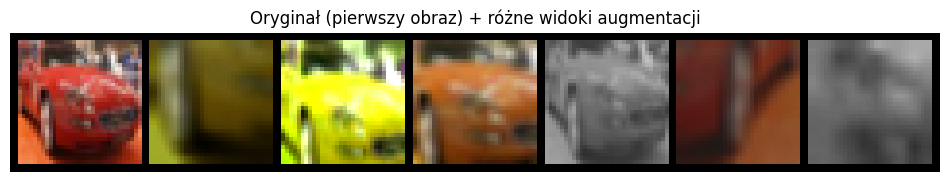

In [6]:
import torchvision

def show_augmented_sample(dataset, idx=0, n_views=6):
    x, _ = dataset[idx]
    # oryginalny obraz (bez augmentacji) do porównania
    to_pil = transforms.ToPILImage()

    base = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
    x0, _ = base[idx]
    imgs = [x0]
    for _ in range(n_views):
        xi, _ = dataset[idx]
        imgs.append(xi)
    grid = torchvision.utils.make_grid(imgs, nrow=n_views+1, padding=2)
    plt.figure(figsize=(12, 3))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Oryginał (pierwszy obraz) + różne widoki augmentacji')
    plt.show()

print('Podgląd augmentacji:')
show_augmented_sample(train_dataset, idx=5, n_views=6)

# Loader ewaluacyjny (test) do t‑SNE i linear probe
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_set = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)
if FAST:
    test_set = Subset(test_set, list(range(2000)))

test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=NUM_WORKERS)

### Definicja modelu
Uzupełnij definicję klasy SimCLRModel, aby uzyskać sieć z następującymi parametrami:
- warstwa wejściowa: 512 wejść i 256 wyjść,
- funkcją aktywacji ReLU między pierwszą i drugą warstwą
- warstwę wyjściową: 256 wejść, wyjście oparte na zmiennej _projection_dim_

In [7]:
class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = base_encoder
        self.encoder.fc = nn.Identity()
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection(features)
        return projections

model = SimCLRModel(models.resnet18(weights=models.ResNet18_Weights.DEFAULT)).to(device)

### MLP i normalizacja
"Projection head" (MLP) rzutuje cechy encodera `h` do nowej przestrzeni reprezentacji `z`, w której obliczane jest podobieństwo oraz funkcja straty kontrastywnej.
W praktyce:
- Używa się niewielkiej sieci MLP z funkcją aktywacji ReLU, która daje lepsze wyniki niż pojedyncza warstwa liniowa.-
- Często stosuje się normalizację L2 wektorów `z`, co powoduje, że mają one długość równą 1. Dzięki temu podobieństwo cosinusowe zależy wyłącznie od kąta między wektorami, a nie od ich skali.
- Projection head jest używany wyłącznie podczas uczenia kontrastywnego. W ewaluacji liniowej (linear probe) wykorzystuje się bezpośrednio cechy encodera h, bez warstwy projekcyjnej.).


Uzupełnij poniższy kod, aby wyświetlić podstawowe statystyki modelu oraz zmierzyć czas wykonania pojedynczego przejścia w przód (forward pass).


In [8]:
# Statystyki modelu i szybki benchmark

def count_parameters(m: nn.Module):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_parameters(model)
print(f"Parametry (łącznie): {total/1e6:.2f} M | Trenowalne: {trainable/1e6:.2f} M")
print(model.encoder.__class__.__name__, "→ projection_dim:", 128)

bs = 128 if device == 'cuda' else 64
x_dummy = torch.randn(bs, 3, 32, 32, device=device)
# warmup
_ = model(x_dummy)
if device == 'cuda':
    torch.cuda.synchronize()

start = time.time()
_ = model(x_dummy)
if device == 'cuda':
    torch.cuda.synchronize()
elapsed = (time.time() - start) * 1000
print(f"Czas forward dla batch={bs}: {elapsed:.1f} ms")

Parametry (łącznie): 11.34 M | Trenowalne: 11.34 M
ResNet → projection_dim: 128
Czas forward dla batch=64: 56.4 ms


### Definicja funkcji contrastive loss (NT‑Xent)

NT-Xent (Normalized Temperature-scaled Cross Entropy) to funkcja straty kontrastywnej, która porównuje każdą reprezentację z jej pozytywnym odpowiednikiem w obrębie tej samej paczki, traktując wszystkie pozostałe reprezentacje jako przykłady negatywne.

Intuicyjnie celem jest maksymalizacja podobieństwa cosinusowego między parami pozytywnymi oraz minimalizacja podobieństwa między parami negatywnymi.
Temperatura τ kontroluje „ostrość” rozkładu softmax — mniejsze wartości τ powodują większe rozróżnienie między podobieństwami, wzmacniając wpływ najbardziej podobnych i najbardziej niepodobnych przykładów.

W praktyce wektory projekcji z są normalizowane do normy L2, co powoduje, że mają długość równą 1. Dzięki temu iloczyn skalarny między wektorami odpowiada podobieństwu
cosinusowemu, które jest następnie wykorzystywane w funkcji straty.

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)
        sim_matrix = torch.mm(z, z.T) / self.temperature
        sim_matrix = sim_matrix - torch.eye(batch_size * 2).to(z.device) * 1e9
        labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)]).to(z.device)
        loss = nn.CrossEntropyLoss()(sim_matrix, labels)
        return loss

contrastive_loss = ContrastiveLoss()

### Trening modelu



In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

hist_loss = []
hist_time = []

for epoch in range(epochs):
    t0 = time.time()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for batch_idx, (images, _) in enumerate(pbar, start=1):
        images = images.to(device)
        # pozytywna para: dwa niezależne widoki tego samego obrazu
        images = torch.cat([images, images], dim=0)
        z_i, z_j = model(images).chunk(2, dim=0)

        loss = contrastive_loss(z_i, z_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(avg_loss=f"{running_loss/batch_idx:.4f}")

    avg_ep = running_loss/len(train_loader)
    hist_loss.append(avg_ep)
    hist_time.append(time.time() - t0)
    print(f"Epoch [{epoch+1}/{epochs}] done | avg_loss: {avg_ep:.4f} | time: {hist_time[-1]:.1f}s")


Epoch 1/1: 100%|██████████| 391/391 [10:55<00:00,  1.68s/batch, avg_loss=499999811.7647]

Epoch [1/1] done | avg_loss: 499999811.7647 | time: 655.1s


### Wykres straty treningowej i statystyk czasu

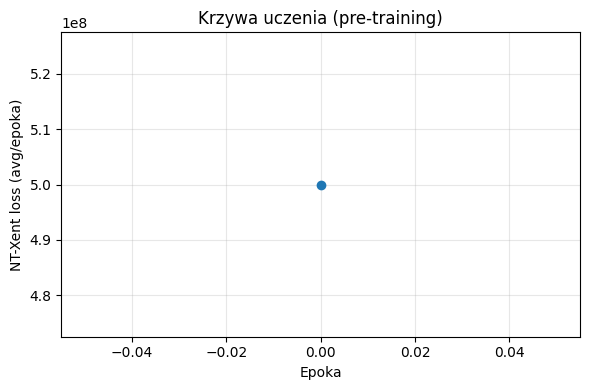

Średni czas/epoka: 655.1s ± 0.0s (n=1)


In [11]:
plt.figure(figsize=(6,4))
plt.plot(hist_loss, marker='o')
plt.xlabel('Epoka')
plt.ylabel('NT-Xent loss (avg/epoka)')
plt.title('Krzywa uczenia (pre‑training)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Średni czas/epoka: {np.mean(hist_time):.1f}s ± {np.std(hist_time):.1f}s (n={len(hist_time)})")

## Wizualizacja embeddingów (t‑SNE)

Porównajmy rozkład reprezentacji przed i po pre‑trainingu.


Ekstrakcja embeddingów do t‑SNE
t‑SNE


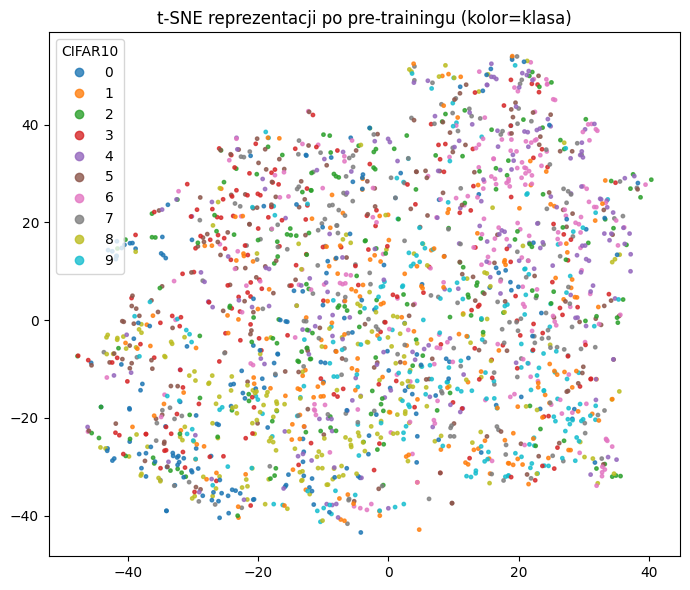

In [12]:
@torch.no_grad()
def extract_embeddings(model, loader, max_batches=20):
    model.eval()
    embs = []
    labels = []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        h = model.encoder(x)
        embs.append(h.cpu().numpy())
        labels.append(y.numpy())
        if i+1 >= max_batches:
            break
    embs = np.concatenate(embs, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embs, labels

print("Ekstrakcja embeddingów do t‑SNE")
embs, labs = extract_embeddings(model, test_loader, max_batches=30 if not FAST else 10)

print("t‑SNE")
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
XY = tsne.fit_transform(embs)

plt.figure(figsize=(7,6))
scatter = plt.scatter(XY[:,0], XY[:,1], c=labs, s=6, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="CIFAR10")
plt.title("t‑SNE reprezentacji po pre‑trainingu (kolor=klasa)")
plt.tight_layout()
plt.show()


## Ewaluacja liniowa

Zamrażamy encoder (jego wagi nie są już aktualizowane) i uczymy niewielki klasyfikator liniowy na podstawie generowanych przez niego cech `h`.
Jest to szybka metoda oceny jakości reprezentacji wyuczonych w procesie uczenia samonadzorowanego.


In [13]:
class LinearProbe(nn.Module):
    def __init__(self, in_dim: int, num_classes: int = 10):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

@torch.no_grad()
def infer_features(encoder, loader):
    encoder.eval()
    X, Y = [], []
    for x, y in loader:
        x = x.to(device)
        h = encoder(x)
        X.append(h.cpu())
        Y.append(y)
    return torch.cat(X), torch.cat(Y)

# Zamrożenie encodera
for p in model.encoder.parameters():
    p.requires_grad_(False)

# Dane do linear probe (cały test_set jako eval; do treningu weźmy część train_base z lekką transformacją)
train_lin = datasets.CIFAR10(root="./data", train=True, download=False, transform=test_transform)
if FAST:
    train_lin = Subset(train_lin, list(range(6000)))

train_lin_loader = DataLoader(train_lin, batch_size=256, shuffle=False, num_workers=NUM_WORKERS)

Xtr, Ytr = infer_features(model.encoder, train_lin_loader)
Xte, Yte = infer_features(model.encoder, test_loader)

probe = LinearProbe(in_dim=Xtr.size(1), num_classes=10).to(device)
opt = torch.optim.Adam(probe.parameters(), lr=5e-3)
ce = nn.CrossEntropyLoss()

def train_probe(probe, Xtr, Ytr, Xte, Yte, epochs=EPOCHS_LINEAR):
    probe.train()
    dataset = torch.utils.data.TensorDataset(Xtr, Ytr)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    for ep in range(1, epochs+1):
        loss_ep = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = probe(xb)
            loss = ce(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_ep += loss.item()
        with torch.no_grad():
            probe.eval()
            te_logits = probe(Xte.to(device))
            pred = te_logits.argmax(dim=1).cpu()
            acc = (pred == Yte).float().mean().item()
            probe.train()
        print(f"Ep {ep}/{epochs} | loss={loss_ep/len(loader):.4f} | test acc={acc*100:.2f}%")

print("Trening linear probe...")
train_probe(probe, Xtr, Ytr, Xte, Yte, epochs=EPOCHS_LINEAR)


E:\Projekty\AiPO\Projekt4A\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Trening linear probe...
Ep 1/3 | loss=2.1362 | test acc=31.00%
Ep 2/3 | loss=1.7815 | test acc=33.70%
Ep 3/3 | loss=1.6868 | test acc=34.50%


## Zadania do wykonania

- Jaki wpływ będzie miała zmiana temperatury `tau` w NT-Xent na _loss_ i _linear probe_? Wypróbuj wartości 0.07 i 0.5
- Wypróbuj 2-3 różne zestawy augmentacji i zapisz wyniki (np. usuń/zmień GaussianBlur, ColorJitter, scale w RandomResizedCrop).
- Przeanalizuj wpływ rozmiaru batcha na wyniki — większy batch zapewnia więcej przykładów negatywnych, ale wydłuża czas obliczeń.
- Wydłuż pre‑training do 5–10 epok (na GPU) i przetestuj program.
- Przetestuj model na innym zbiorze danych, np. STL10 z wykorzystaniem części nieetykietowanej.